# Pattern Analysis and Classification

In [1]:
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from PIL import Image 
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog

## Build dataset

In [2]:
def load_dataset(folder_path):
    origin_images = []
    images = []
    paths = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)

            img = Image.open(file_path)
            img = img.resize((100, 100))  # Ensure the image size is 100x100
            # If the image has 4 channels (RGBA), convert to 3 channels (RGB)
            data = np.array(img)
            if data.shape[2] == 4:
                data = data[:, :, :3]
            
            origin_images.append(data)

            img = img.convert('L')  # Convert image to grayscale
            images.append(np.array(img))

            paths.append(file_path)
    return np.array(images), paths, np.array(origin_images)

dataset_path = './turing_dataset'
imgs, paths, ori_imgs = load_dataset(dataset_path)
labels = np.arange(imgs.shape[0])
print("Shape of the dataset:", imgs.shape)

Shape of the dataset: (2048, 100, 100)


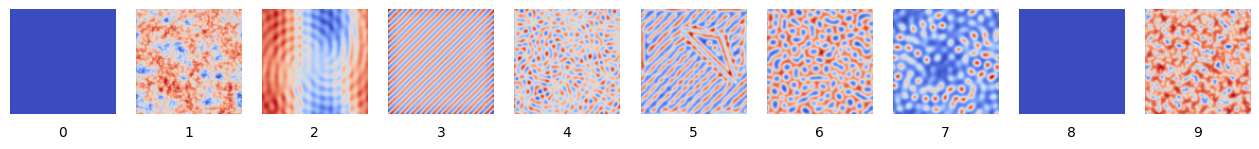

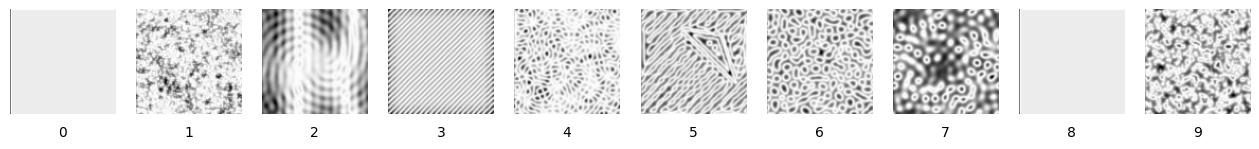

In [3]:
# Display some images to confirm they are correct
def display_ori_images(images, num_images=5):
    plt.figure(figsize=(16, 1.5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.text(0.5, -0.1, labels[i], ha='center', va='top', transform=plt.gca().transAxes)
        plt.axis('off')
    plt.show()

def display_images(images, num_images=5):
    plt.figure(figsize=(16, 1.5))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.text(0.5, -0.1, labels[i], ha='center', va='top', transform=plt.gca().transAxes)
        plt.axis('off')
    plt.show()

display_ori_images(ori_imgs, num_images=10)
display_images(imgs, num_images=10)

## Data statistics visualization

In [4]:
# Flatten the training and test images
x_orig = imgs
y_orig = labels
x_flatten = x_orig.reshape(x_orig.shape[0], -1)

# Normalize image vectors
X = x_flatten / 255

# Explore dataset 
print ("number of examples = " + str(X.shape[0]))
print ("X shape: ", X.shape)
print ("Y shape: ", y_orig.shape)

number of examples = 2048
X shape:  (2048, 10000)
Y shape:  (2048,)


In [5]:
# Collect statistic
def gradient_vec(X):
    g_X_r = np.gradient(X, axis = 1)
    g_X_c = np.gradient(X, axis = 0)
    g_X = g_X_r**2 + g_X_c**2
    return g_X

X1 = np.var(X - X ** 3, axis=1)
X2 = np.mean(gradient_vec(X), axis = 1)
X3 = np.mean(X, axis = 1)

In [6]:
X1 = X1.reshape(-1, 1)
X2 = X2.reshape(-1, 1)
X3 = X3.reshape(-1, 1)

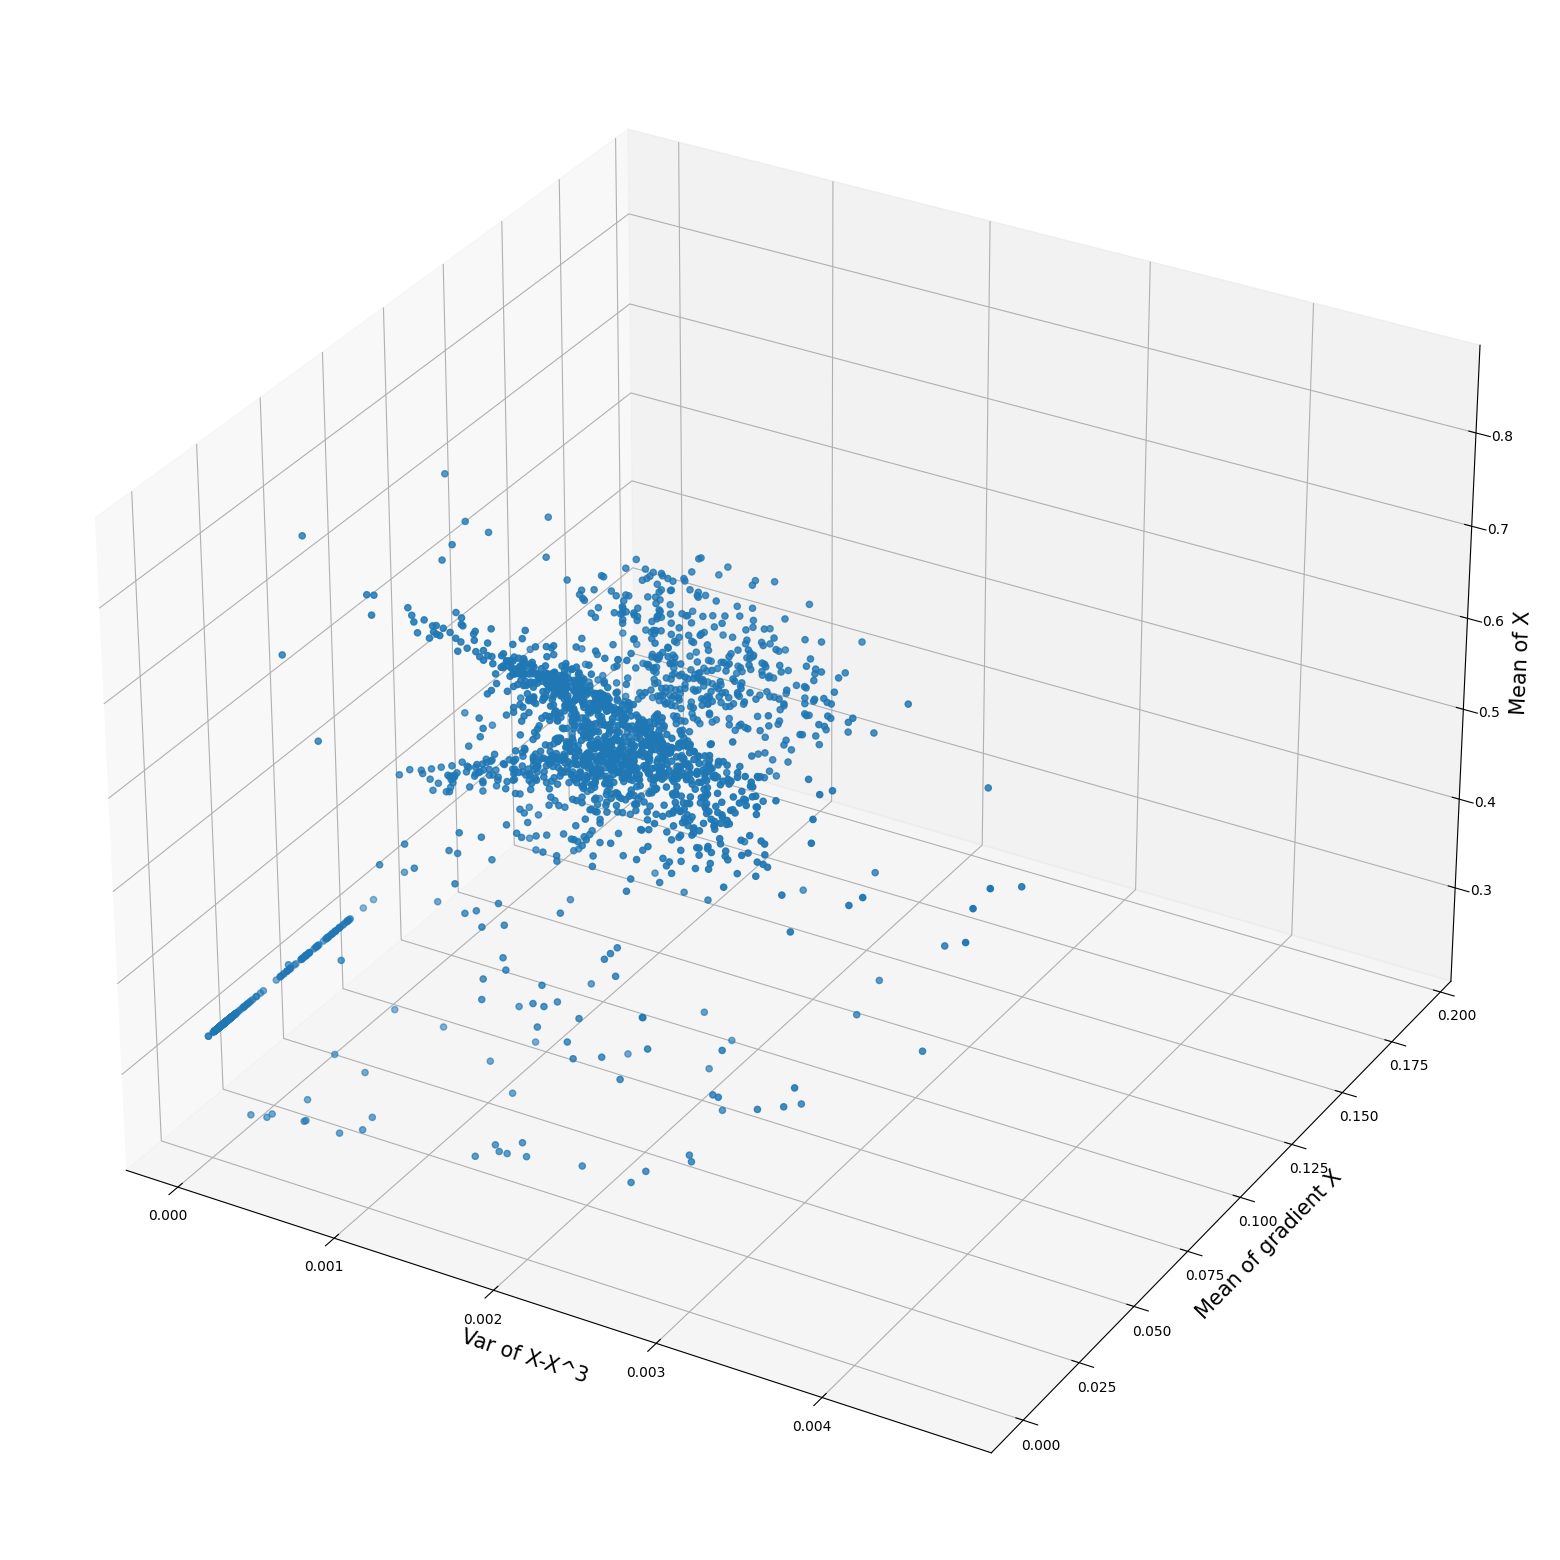

In [7]:
# Visualization
plt.rcParams["figure.figsize"] = (20,20)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') 
ax.scatter(X1, X2, X3)
ax.set_xlabel("Var of X-X^3", fontsize = 15)
ax.set_ylabel("Mean of gradient X", fontsize = 15)
ax.set_zlabel("Mean of X", fontsize = 15)
plt.show()
ax.view_init(45, 45)

## K-means clustering
### Based on statistic data

In [8]:
# Combine the statistic
data = np.concatenate([X1, X2, X3], axis=1)

In [9]:
# Run K-means clustering
num_classes = 10
model = KMeans(init="k-means++", n_clusters=num_classes, random_state=50)
model.fit(data)
y_pred = model.labels_

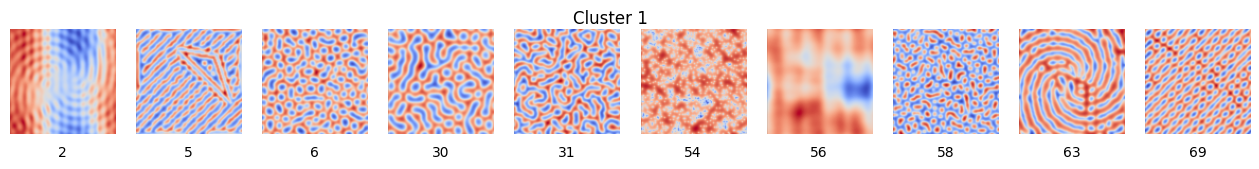

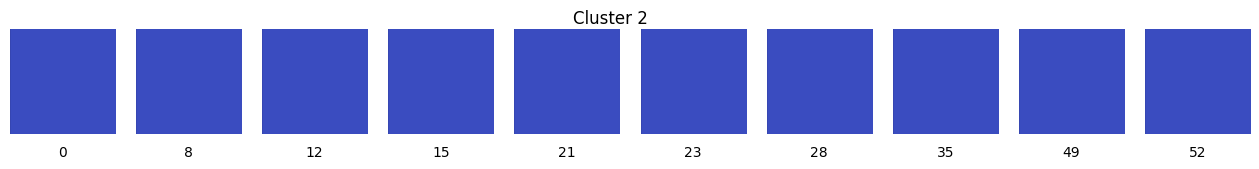

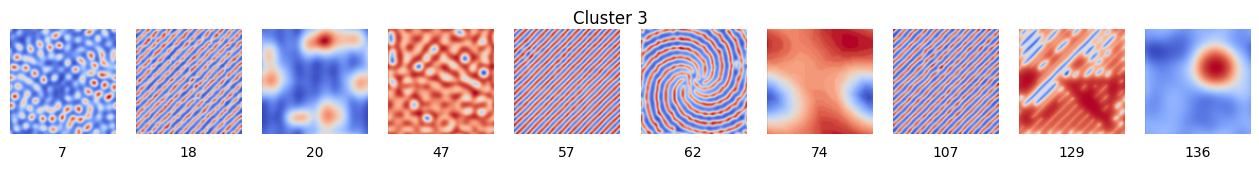

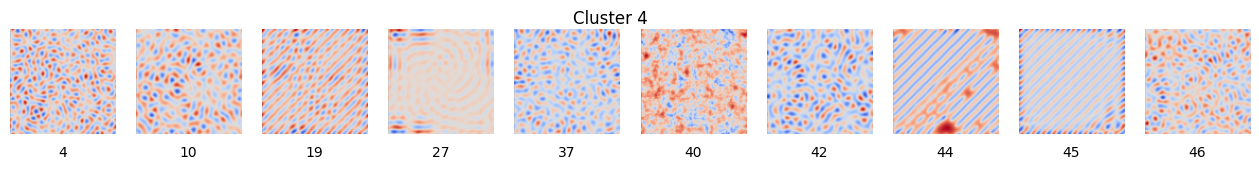

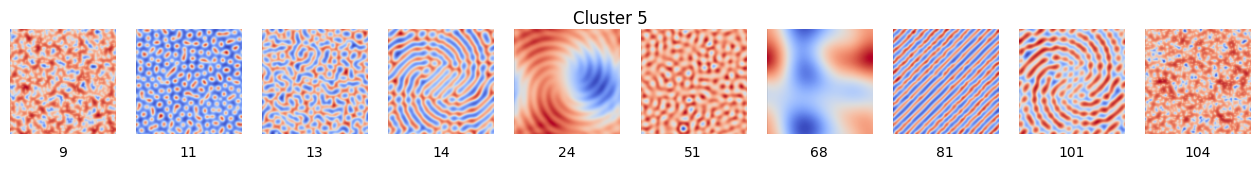

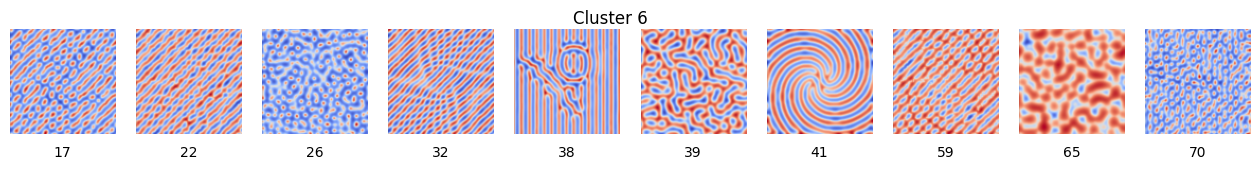

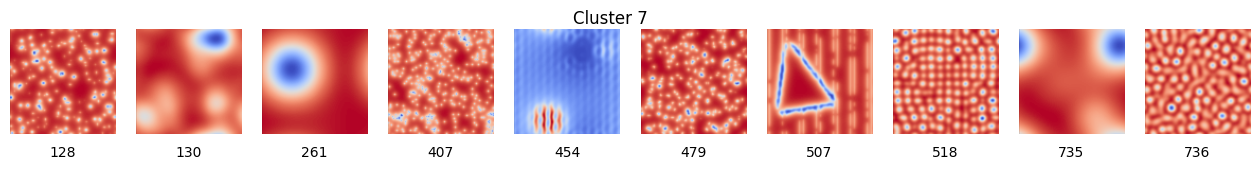

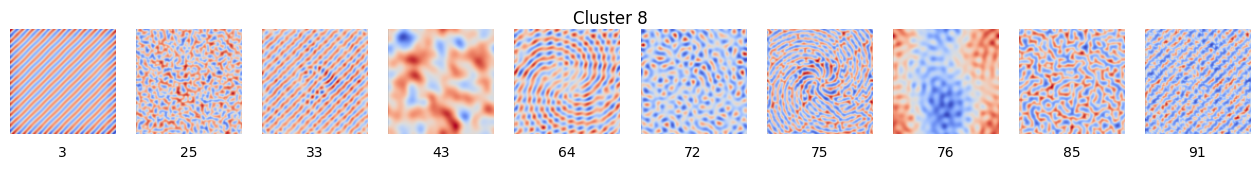

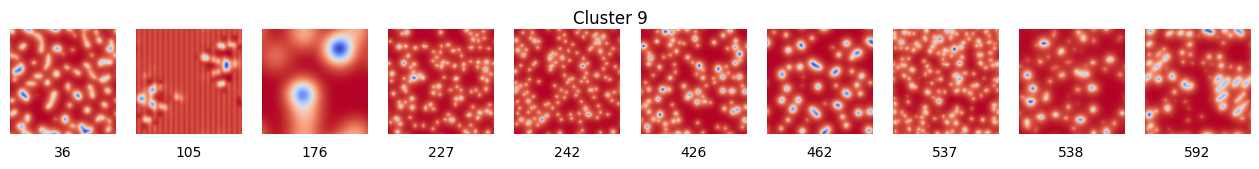

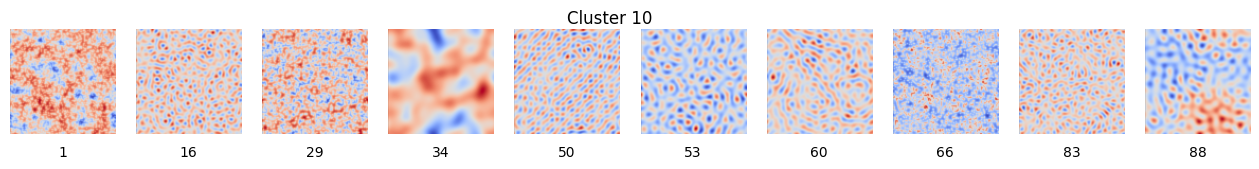

In [10]:
# Check clusters
def plot_cluster_images(ori_imgs, labels, y_pred, num_classes, length=5):
    for cls in range(num_classes):
        labels_y_predi = labels[np.where(y_pred == cls)]
        k = 0
        plt.figure(figsize=(16, 1.5))
        for label in labels_y_predi:
            if k >= length:
                break
            plt.subplot(1, length, k+1)
            plt.imshow(ori_imgs[label])
            plt.text(0.5, -0.1, str(label), ha='center', va='top', transform=plt.gca().transAxes)
            plt.axis('off')
            k += 1
        plt.suptitle(f'Cluster {cls + 1}')
        plt.show()

plot_cluster_images(ori_imgs, labels, y_pred, num_classes, length=10)


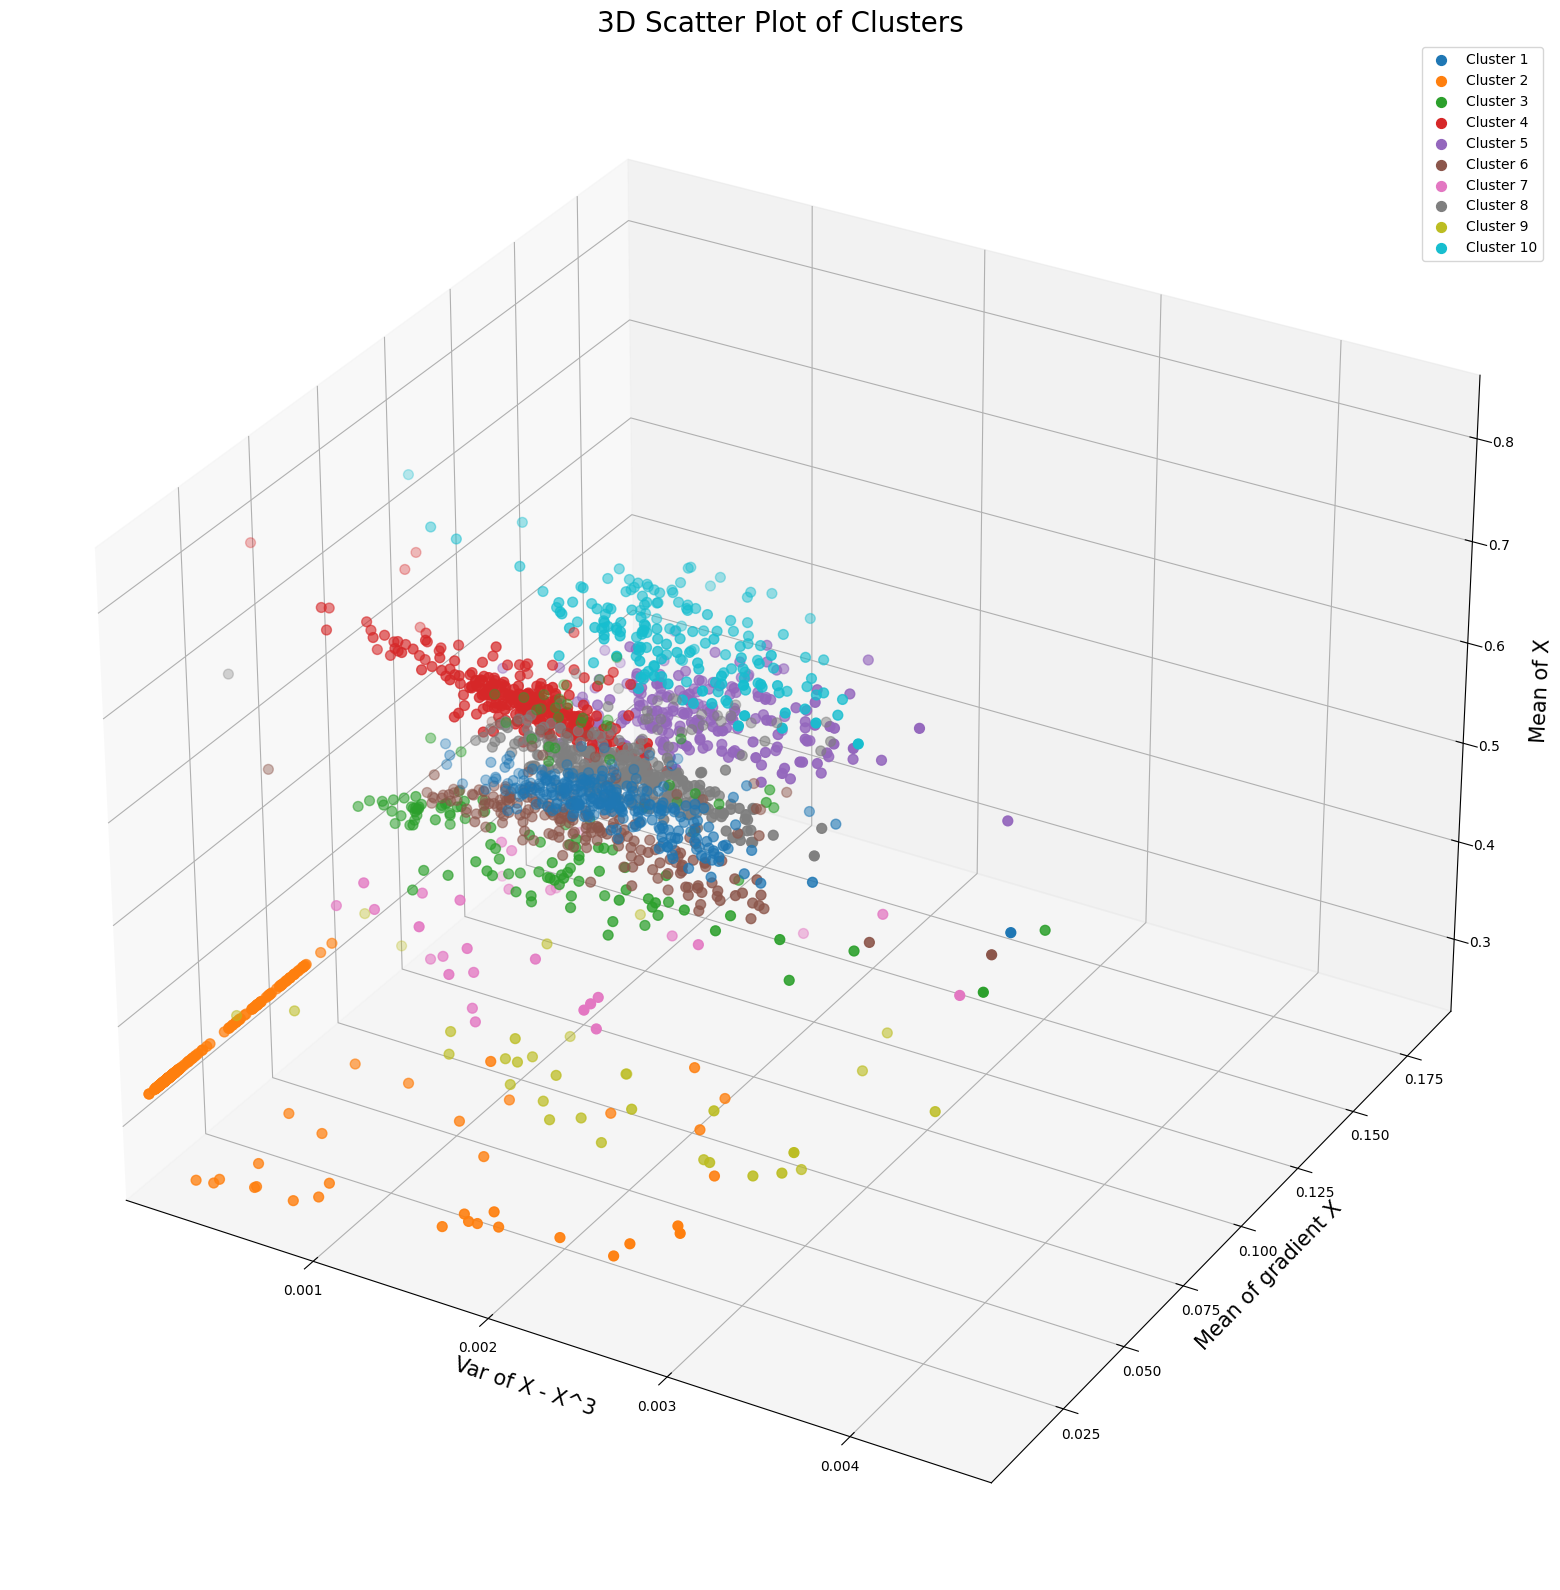

In [11]:
# Set figure parameters
plt.rcParams["figure.figsize"] = (20, 20)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set axes
ax.set_xlim3d(min(X1), max(X1))
ax.set_ylim3d(min(X2), max(X2))
ax.set_zlim3d(min(X3), max(X3))

# Plot
for i in range(num_classes):
    cluster_indices = np.where(y_pred == i)
    ax.scatter(X1[cluster_indices], X2[cluster_indices], X3[cluster_indices], s=50, label=f'Cluster {i + 1}')
ax.set_xlabel("Var of X - X^3", fontsize=15)
ax.set_ylabel("Mean of gradient X", fontsize=15)
ax.set_zlabel("Mean of X", fontsize=15, labelpad=13)
plt.title('3D Scatter Plot of Clusters', loc='center', fontsize=20)
ax.legend()
plt.show()


### Based on high-level feature

In [12]:
features = []

for i in range(imgs.shape[0]):
    # Get an image
    image = imgs[i]
    
    # Calculate HOG feature
    fd, hog_image = hog(image, orientations=16, pixels_per_cell=(8, 8),
                        cells_per_block=(5, 5), visualize=True)

    # plt.figure(figsize=(12, 6))

    # plt.subplot(1, 3, 1)
    # plt.title('Original Image')
    # plt.imshow(image, cmap='gray')
    # plt.axis('off')


    # plt.subplot(1, 3, 3)
    # plt.title('HOG Features')
    # hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    # plt.imshow(hog_image_rescaled, cmap='gray')
    # plt.axis('off')

    # plt.show()
    features.append(fd)
    
features_matrix = np.array(features)

In [13]:
features_matrix.shape

(2048, 25600)

In [14]:
# PCA decomposition
n_components = 100
pca = PCA(n_components=n_components)
reduced_features_matrix = pca.fit_transform(features_matrix)

In [15]:
# K-means clustering
num_classes = 10
model = KMeans(init="k-means++", n_clusters=num_classes, random_state=50)
model.fit(reduced_features_matrix)
y_pred = model.labels_

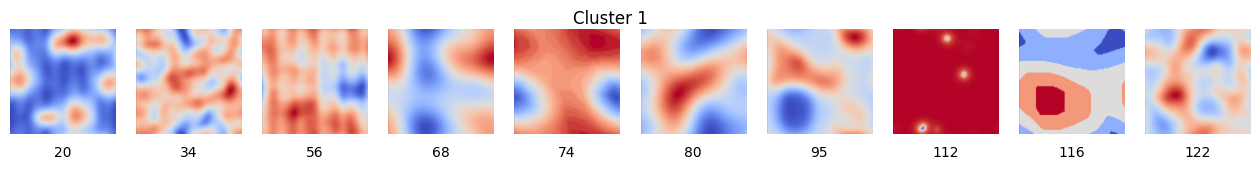

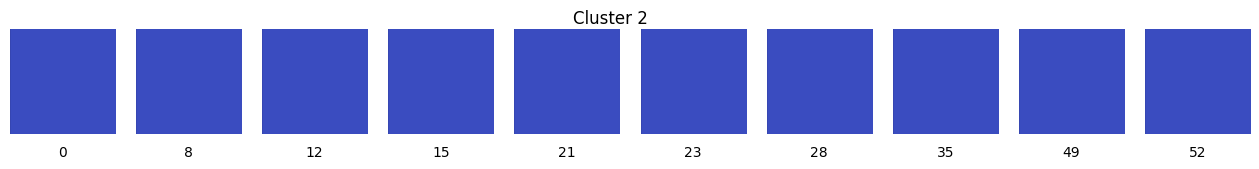

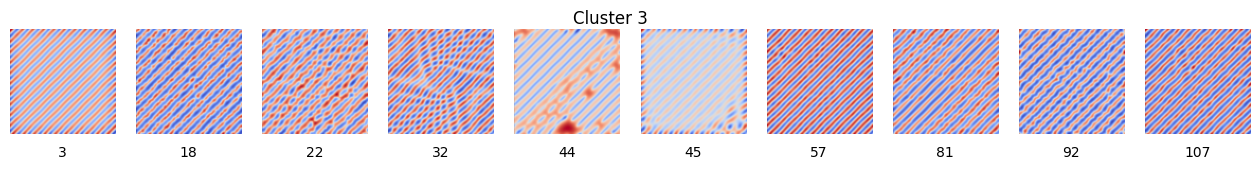

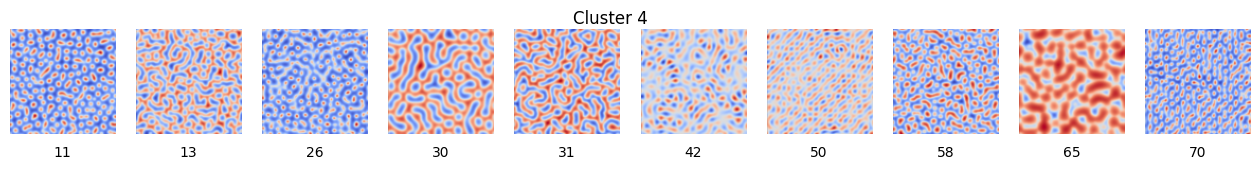

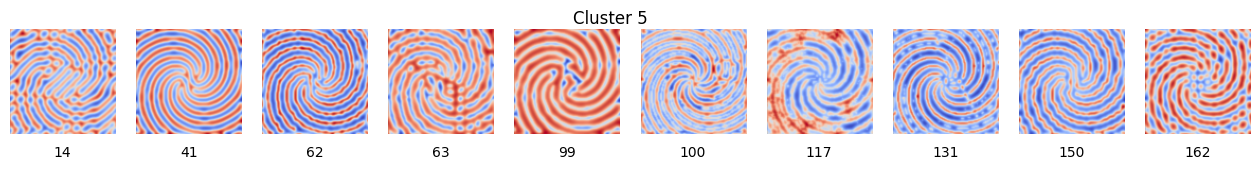

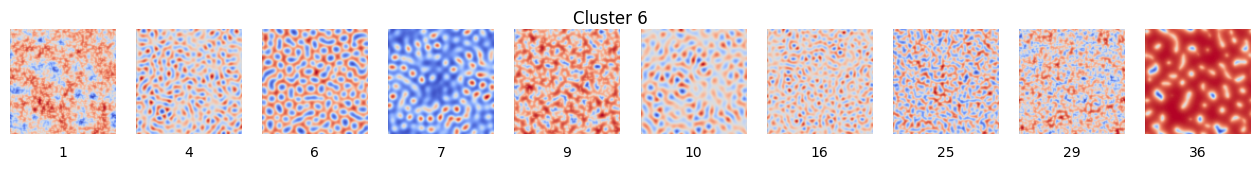

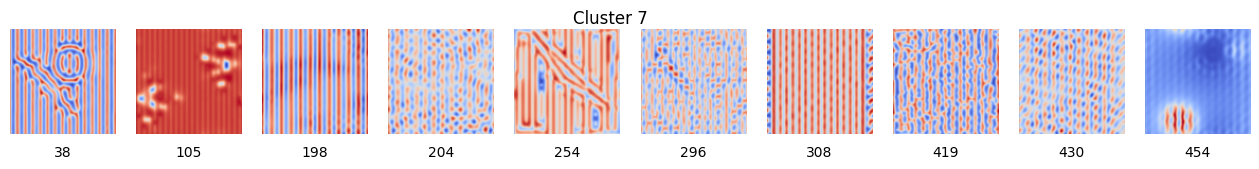

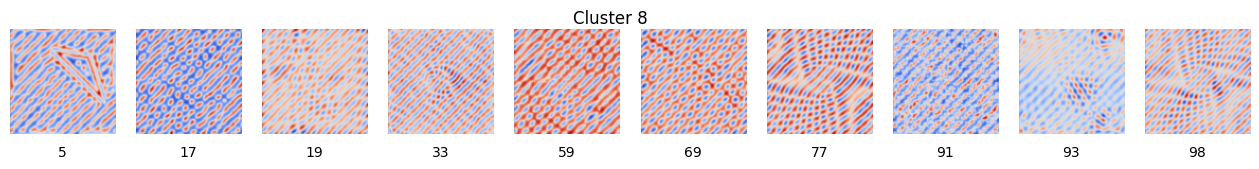

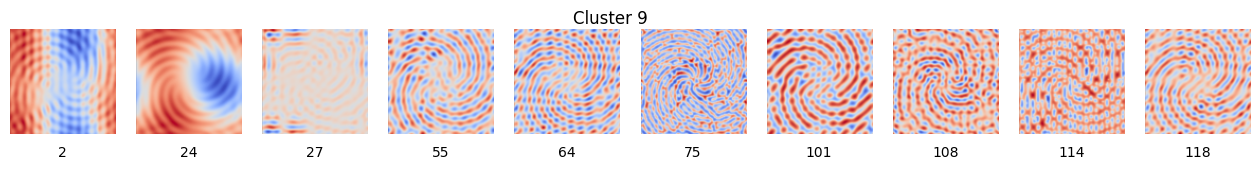

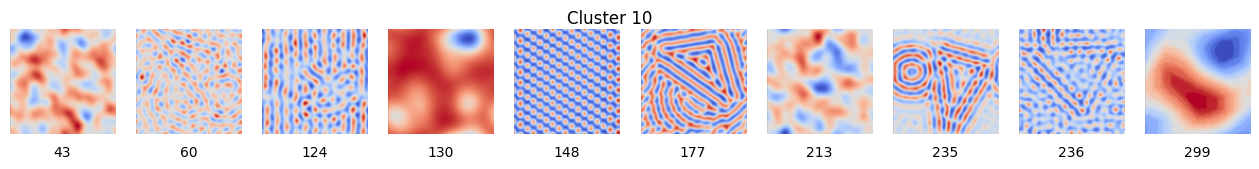

In [16]:
# Check clusters
def plot_cluster_images(ori_imgs, labels, y_pred, num_classes, length=5):
    for cls in range(num_classes):
        labels_y_predi = labels[np.where(y_pred == cls)]
        k = 0
        plt.figure(figsize=(16, 1.5))
        for label in labels_y_predi:
            if k >= length:
                break
            plt.subplot(1, length, k+1)
            plt.imshow(ori_imgs[label])
            plt.text(0.5, -0.1, str(label), ha='center', va='top', transform=plt.gca().transAxes)
            plt.axis('off')
            k += 1
        plt.suptitle(f'Cluster {cls + 1}')
        plt.show()

plot_cluster_images(ori_imgs, labels, y_pred, num_classes, length=10)


In [17]:
# PCA decomposition (used for visualization)
n_components = 3
pca = PCA(n_components=n_components)
reduced_features_matrix = pca.fit_transform(features_matrix)

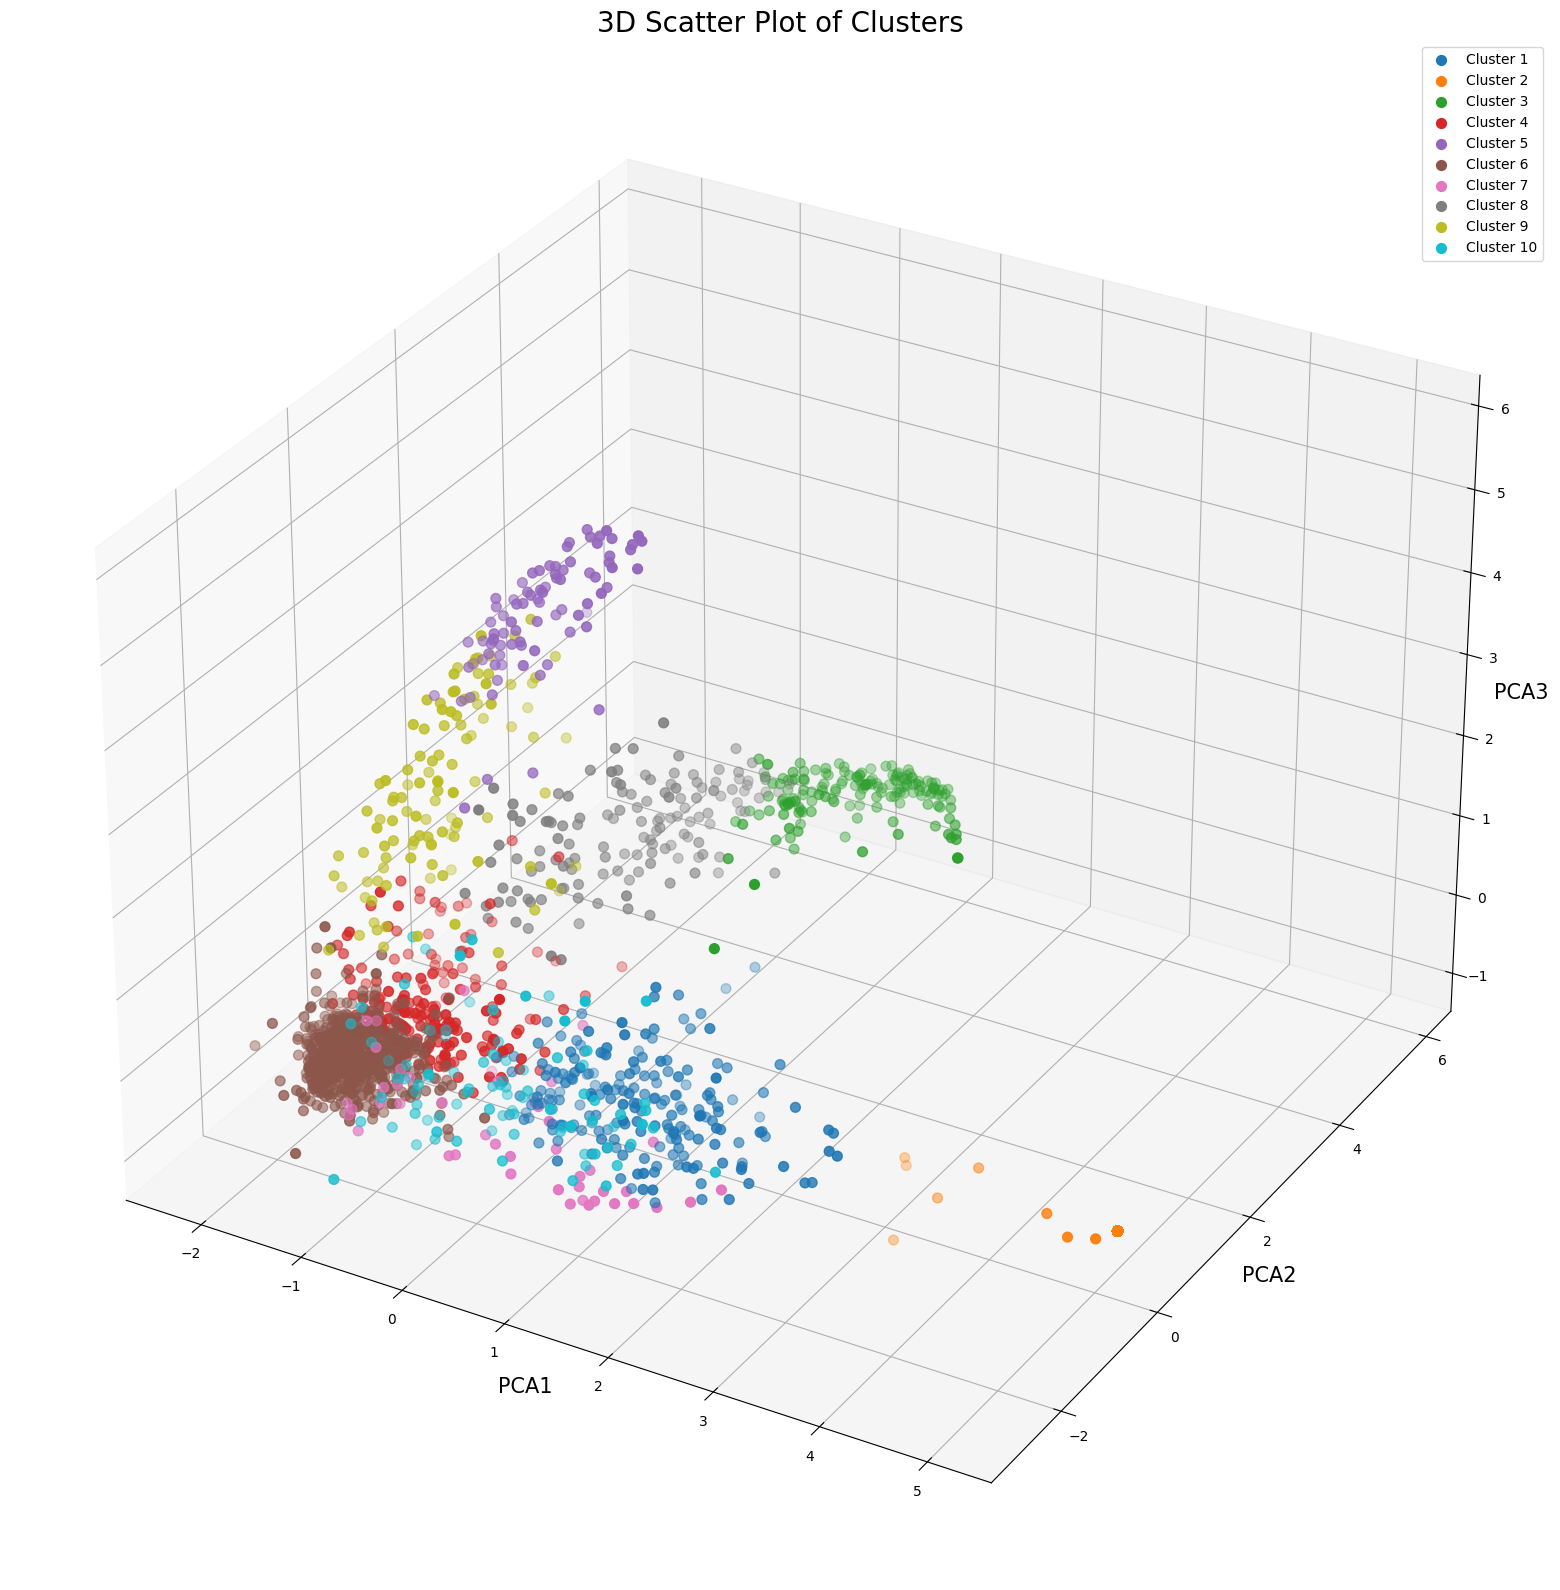

In [18]:
# plot
plt.rcParams["figure.figsize"] = (20, 20)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlim3d(min(reduced_features_matrix[:, 0]), max(reduced_features_matrix[:, 0]))
ax.set_ylim3d(min(reduced_features_matrix[:, 1]), max(reduced_features_matrix[:, 1]))
ax.set_zlim3d(min(reduced_features_matrix[:, 2]), max(reduced_features_matrix[:, 2]))

for i in range(num_classes):
    cluster_indices = np.where(y_pred == i)
    ax.scatter(reduced_features_matrix[cluster_indices, 0], 
               reduced_features_matrix[cluster_indices, 1], 
               reduced_features_matrix[cluster_indices, 2], s=50, label=f'Cluster {i + 1}')
    
ax.set_xlabel("PCA1", fontsize=15)
ax.set_ylabel("PCA2", fontsize=15)
ax.set_zlabel("PCA3", fontsize=15)
plt.title('3D Scatter Plot of Clusters', loc='center', fontsize=20)

ax.legend()

plt.show()
